In [ ]:
  %cd drive/'My Drive'/ex1_predict

/content/drive/My Drive/ex1_predict


In [ ]:
!pip install dtaidistance


     |████████████████████████████████| 327kB 8.7MB/s 
  Created wheel for dtaidistance: filename=dtaidistance-1.2.3-cp36-cp36m-linux_x86_64.whl size=624187 sha256=5b3fffc6968f075c83e8c583efb08bf4a7b28c5a9e474526f8ab2a9f3bbdcbae
  Stored in directory: /root/.cache/pip/wheels/9f/9a/74/42c5b9dc714bb5a70b426df08cc860e6a741bc199004873e1b
Successfully built dtaidistance


In [ ]:
from dtaidistance import dtw
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import json
import enum
import sklearn.preprocessing
import argparse
import tensorflow.compat.v1 as tf
import pickle

In [ ]:
# list_GMfile = np.array(['H-E12140'])
list_GMfile = ['kobe', 'elsalvado', 'indiana', 'fairbank', 'nenana', 'tonalapa', 'taiwan_1', 'taiwan_2', 'kardista', 'santiago', 'lima', 'rarakau', 'simeon']
list_GMfact = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]

In [ ]:
GMfile = []
for i in range(len(list_GMfile)):
    GMfile += [list_GMfile[i]] * len(list_GMfact)

GMfact = list_GMfact * len(list_GMfile)


In [ ]:
def _batch_single_entity(input_data, params):
  data_steps = len(input_data)
  lags = params['total_time_steps']
  x = input_data.values
  if data_steps >= lags:
    return np.stack([x[i:data_steps - (lags - 1) + i, :] for i in range(lags)], axis=1)


In [ ]:
def df_to_data(df, col_mappings, params):
    data_map = {}
    for k in col_mappings:
      cols = col_mappings[k]
      arr = _batch_single_entity(df[cols].copy(), params)

      if k not in data_map:
        data_map[k] = [arr]
      else:
        data_map[k].append(arr)

    # Combine all data
    for k in data_map:
      data_map[k] = np.concatenate(data_map[k], axis=0)

    num_encoder_steps = params['num_encoder_steps']
    data_map['outputs'] = data_map['outputs'][:, num_encoder_steps:, :]
    
    return data_map


In [ ]:
exclude = [94, 95, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159]

col_mappings = {
  'identifier': ['id'],
  'outputs': [1],
  'inputs': [1, 15],
  # 'inputs': [1, 2, 12, 15],
  }


In [ ]:
def get_simulate(id, params):
  df = pd.read_csv(f'{GMfile[id]}.g3', sep=' ', header=None)
  Ncol = len(list(df))
  g = np.zeros(len(df)*Ncol)
  for i in range(Ncol):
      g[i::Ncol]=df[i]

  g = g[~np.isnan(g)]
  g = g[::2]*GMfact[id]
  df = pd.read_csv(f'disp_{id}.out', sep=' ', header=None)
  df = df[:3000]
  df[15] = g
  df['id'] = 'acc'

  return df

In [ ]:
# Combine all df to calculate scaler
df_all = pd.DataFrame()
for i in range(100):
    if i not in exclude:
        df = pd.read_csv(f'{GMfile[i]}.g3', sep=' ', header=None)
        Ncol = len(list(df))
        g = np.zeros(len(df)*Ncol)
        for i in range(Ncol):
            g[i::Ncol]=df[i]

        g = g[~np.isnan(g)]
        g = g[::2]*GMfact[i]
        df = pd.read_csv(f'disp_{i}.out', sep=' ', header=None)
        df = df[:3000]
        df[15] = g
        df['id'] = 'acc'       
        df_all=pd.concat([df_all, df])

real_scalers = sklearn.preprocessing.StandardScaler().fit(df_all[col_mappings['inputs']].values)
output_scalers = sklearn.preprocessing.StandardScaler().fit(df_all[col_mappings['outputs']].values)

In [ ]:
# scaled train data, e.g.: 'inputs': (242649, 550, 4)
params = {}
params['total_time_steps']  = 550
params['num_encoder_steps'] = 500

i = 0
df = get_simulate(i, params)
df[col_mappings['inputs']] = real_scalers.transform(df[col_mappings['inputs']].values)
data_all = df_to_data(df, col_mappings, params)


In [ ]:
for i in range(100):
    if i not in exclude:
        if i%20 == 0:
          print(i)        

        df = get_simulate(i, params)
        df[col_mappings['inputs']] = real_scalers.transform(df[col_mappings['inputs']].values)
        data_map = df_to_data(df, col_mappings, params)
        data_all['inputs'] = np.concatenate((data_all['inputs'], data_map['inputs']), axis = 0)
        data_all['outputs'] = np.concatenate((data_all['outputs'], data_map['outputs']), axis = 0)

0
20
40
60
80


In [ ]:
print(np.shape(data_all['inputs']))
print(np.shape(data_all['outputs']))

(242649, 550, 2)
(242649, 50, 1)


In [ ]:
Nsplit = 5000
data, labels = data_all['inputs'][:-Nsplit], data_all['outputs'][:-Nsplit] 
val_data, val_labels = data_all['inputs'][-Nsplit:], data_all['outputs'][-Nsplit:] 

In [ ]:
print(data.shape)
print(val_data.shape)

(237649, 550, 2)
(5000, 550, 2)


In [ ]:
N_input_size = len(col_mappings['inputs'])

params = {
 'dropout_rate': 0.1,
 'early_stopping_patience': 5,
 'hidden_layer_size': 160,
 'input_obs_loc': [0],
 'input_size': N_input_size,
#  'known_regular_inputs': list(range(1,N_input_size)),
 'known_regular_inputs': [N_input_size-1],
 'learning_rate': 0.001,
 'max_gradient_norm': 0.01,
 'minibatch_size': 256,
 'model_folder': 'electricity/saved_models/electricity/fixed',
 'multiprocessing_workers': 5,
 'num_encoder_steps': 500,
 'num_epochs': 100,
 'num_heads': 4,
 'output_size': 1,
 'stack_size': 1,
  'total_time_steps': 550}

In [ ]:
name, output_folder, use_tensorflow_with_gpu = 'ex1', 'ex1', 'yes'
default_keras_session = tf.keras.backend.get_session()
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = str(0)
tf_config = tf.compat.v1.ConfigProto(log_device_placement=False)
tf_config.gpu_options.allow_growth = True
tf.global_variables_initializer()


In [ ]:
all_callbacks = [
    tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=params['early_stopping_patience'], min_delta=1e-4),
    tf.keras.callbacks.ModelCheckpoint( filepath=os.path.join(params['model_folder'], 'bbb.check'), monitor='val_loss',
        save_best_only=True, save_weights_only=True),
    tf.keras.callbacks.TerminateOnNaN(),
    tf.keras.callbacks.ProgbarLogger(count_mode="samples", stateful_metrics=None)    ]


In [ ]:
def get_active_locations(x):
  """Formats sample weights for Keras training."""
  return (np.sum(x, axis=-1) > 0.0) * 1.0


In [ ]:
all_inputs = tf.keras.layers.Input(shape=(params['total_time_steps'], params['input_size'],))


In [ ]:
def convert_real_to_embedding(x):
  return tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(params['hidden_layer_size']))(x)



In [ ]:
def gated_residual_network(x, hidden_layer_size, output_size=None, dropout_rate=None,
                           use_time_distributed=True, additional_context=None, return_gate=False):

  # Setup skip connection
  if output_size is None:
    output_size = hidden_layer_size
    skip = x
  else:
    linear = tf.keras.layers.Dense(output_size)
    if use_time_distributed:
      linear = tf.keras.layers.TimeDistributed(linear)
    skip = linear(x)

  # Apply feedforward network
  hidden = linear_layer( hidden_layer_size, activation=None, use_time_distributed=use_time_distributed)(x) 
  hidden = tf.keras.layers.Activation('elu')(hidden)
  hidden = linear_layer(hidden_layer_size, activation=None, use_time_distributed=use_time_distributed)(hidden)
  gating_layer, gate = apply_gating_layer( hidden,output_size,dropout_rate=dropout_rate, 
                                          use_time_distributed=use_time_distributed, activation=None)

  if return_gate:
    return add_and_norm([skip, gating_layer]), gate
  else:
    return add_and_norm([skip, gating_layer])


In [ ]:
def linear_layer(size, activation=None, use_time_distributed=False, use_bias=True):

  linear = tf.keras.layers.Dense(size, activation=activation, use_bias=use_bias)
  if use_time_distributed:
    linear = tf.keras.layers.TimeDistributed(linear)
  return linear

In [ ]:
def apply_gating_layer(x, hidden_layer_size, dropout_rate=None, use_time_distributed=True, activation=None):

  if dropout_rate is not None:
    x = tf.keras.layers.Dropout(dropout_rate)(x)

  if use_time_distributed:
    activation_layer = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dense(hidden_layer_size, activation=activation))(x)
    
    gated_layer = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dense(hidden_layer_size, activation='sigmoid'))(x)
  
  else:
    activation_layer = tf.keras.layers.Dense(
        hidden_layer_size, activation=activation)(x)

    gated_layer = tf.keras.layers.Dense(
        hidden_layer_size, activation='sigmoid')(x)

  return tf.keras.layers.Multiply()([activation_layer,gated_layer]), gated_layer


In [ ]:
def add_and_norm(x_list):
  tmp = tf.keras.layers.Add()(x_list)
  tmp = tf.keras.layers.LayerNormalization()(tmp)
  return tmp


In [ ]:
def get_decoder_mask(self_attn_inputs):
  len_s = tf.shape(self_attn_inputs)[1]
  bs = tf.shape(self_attn_inputs)[:1]  
  mask = tf.keras.backend.cumsum(tf.eye(len_s, batch_shape=bs), 1)
  return mask


In [ ]:
num_encoder_steps = int(params['num_encoder_steps'])
output_size = int(params['output_size'])
quantiles = [0.1, 0.5, 0.9]


In [ ]:
def tensorflow_quantile_loss(y, y_pred, quantile):
  prediction_underflow = y - y_pred
  q_loss = quantile * tf.maximum(prediction_underflow, 0.) + (
      1. - quantile) * tf.maximum(-prediction_underflow, 0.)

  return tf.reduce_sum(q_loss, axis=-1)

In [ ]:
class QuantileLossCalculator(object):
  def __init__(self, quantiles):
    self.quantiles = quantiles

  def quantile_loss(self, a, b):
    quantiles_used = set(self.quantiles)

    loss = 0.
    for i, quantile in enumerate(valid_quantiles):
      if quantile in quantiles_used:
        loss += tensorflow_quantile_loss(
            a[Ellipsis, output_size * i:output_size * (i + 1)],
            b[Ellipsis, output_size * i:output_size * (i + 1)], quantile)
    return loss

In [ ]:
max_gradient_norm = float(params['max_gradient_norm'])
learning_rate = float(params['learning_rate'])
adam = tf.keras.optimizers.Adam(lr=learning_rate, clipnorm=max_gradient_norm)
valid_quantiles = quantiles
quantile_loss = QuantileLossCalculator(valid_quantiles).quantile_loss
minibatch_size = int(params['minibatch_size'])
n_multiprocessing_workers = int(params['multiprocessing_workers'])

In [ ]:
def temp(all_inputs, params):
  time_steps = int(params['total_time_steps'])
  combined_input_size = int(params['input_size'])
  encoder_steps = int(params['num_encoder_steps'])
  hidden_layer_size = int(params['hidden_layer_size'])
  _known_regular_input_idx = json.loads(str(params['known_regular_inputs']))
  dropout_rate = float(params['dropout_rate'])
  input_size = int(params['input_size'])
  num_regular_variables = input_size 

  regular_inputs = all_inputs[:, :, :num_regular_variables]
  # Targets
  _input_obs_loc = json.loads(str(params['input_obs_loc']))
  obs_inputs = tf.keras.backend.stack([
  convert_real_to_embedding(regular_inputs[Ellipsis, i:i + 1]) for i in _input_obs_loc], axis=-1)
  unknown_inputs = []
  for i in range(regular_inputs.shape[-1]):
    if i not in _known_regular_input_idx and i not in _input_obs_loc:
      e = convert_real_to_embedding(regular_inputs[Ellipsis, i:i + 1])
      unknown_inputs.append(e)

  known_regular_inputs = [
      convert_real_to_embedding(regular_inputs[Ellipsis, i:i + 1])
      for i in _known_regular_input_idx]

  known_combined_layer = tf.keras.backend.stack(known_regular_inputs, axis=-1)
  historical_inputs = tf.keras.backend.concatenate([known_combined_layer[:, :encoder_steps, :], obs_inputs[:, :encoder_steps, :]],axis=-1)
  future_inputs = known_combined_layer[:, encoder_steps:, :]
  _, time_steps, embedding_dim, num_inputs = historical_inputs.get_shape().as_list()
  flatten = tf.keras.backend.reshape(historical_inputs, [-1, time_steps, embedding_dim * num_inputs])
  mlp_outputs, _ = gated_residual_network( flatten, hidden_layer_size, output_size=num_inputs, dropout_rate= dropout_rate,
            use_time_distributed=True, return_gate=True)

  sparse_weights = tf.keras.layers.Activation('softmax')(mlp_outputs)
  sparse_weights = tf.expand_dims(sparse_weights, axis=2)

  trans_emb_list = []
  for i in range(num_inputs):
    grn_output = gated_residual_network( historical_inputs[Ellipsis, i], hidden_layer_size, dropout_rate=dropout_rate,
        use_time_distributed=True)
    trans_emb_list.append(grn_output)

  transformed_embedding = tf.keras.backend.stack(trans_emb_list, axis=-1)
  combined = tf.keras.layers.Multiply()([sparse_weights, transformed_embedding])
  temporal_ctx = tf.keras.backend.sum(combined, axis=-1)
  historical_features, historical_flags = temporal_ctx, sparse_weights

  _, time_steps, embedding_dim, num_inputs = future_inputs.get_shape().as_list()
  flatten = tf.keras.backend.reshape(future_inputs, [-1, time_steps, embedding_dim * num_inputs])
  
  mlp_outputs, _ = gated_residual_network(flatten,hidden_layer_size, output_size=num_inputs,dropout_rate=dropout_rate,
            use_time_distributed=True, return_gate=True)

  sparse_weights = tf.keras.layers.Activation('softmax')(mlp_outputs)
  sparse_weights = tf.expand_dims(sparse_weights, axis=2)

  trans_emb_list = []
  for i in range(num_inputs):
    grn_output = gated_residual_network( future_inputs[Ellipsis, i], hidden_layer_size, dropout_rate=dropout_rate,
        use_time_distributed=True)
    trans_emb_list.append(grn_output)

  transformed_embedding = tf.keras.backend.stack(trans_emb_list, axis=-1)
  combined = tf.keras.layers.Multiply()([sparse_weights, transformed_embedding])
  temporal_ctx = tf.keras.backend.sum(combined, axis=-1)
  future_features, future_flags = temporal_ctx, sparse_weights
  history_lstm, state_h, state_c = tf.compat.v1.keras.layers.CuDNNLSTM(hidden_layer_size, return_sequences=True, return_state=True, stateful=False)(historical_features)
  future_lstm = tf.compat.v1.keras.layers.CuDNNLSTM(hidden_layer_size, return_sequences=True, return_state=False, stateful=False)(future_features, initial_state=[state_h, state_c])
  lstm_layer = tf.keras.backend.concatenate([history_lstm, future_lstm], axis=1)
  lstm_layer, _ = apply_gating_layer(lstm_layer, hidden_layer_size, dropout_rate, activation=None)
  input_embeddings = tf.keras.backend.concatenate([historical_features, future_features], axis=1)
  temporal_feature_layer = add_and_norm([lstm_layer, input_embeddings])
  enriched, _ = gated_residual_network(temporal_feature_layer, hidden_layer_size, dropout_rate=dropout_rate,
          use_time_distributed=True, return_gate=True)

  # Attention
  num_heads = int(params['num_heads'])
  mask = get_decoder_mask(enriched)
  heads = []
  d_k = d_v = hidden_layer_size // num_heads

  for i in range(num_heads):
    q = tf.keras.layers.Dense(d_k, use_bias=False)(enriched)
    k = tf.keras.layers.Dense(d_k, use_bias=False)(enriched)
    v = tf.keras.layers.Dense(d_k, use_bias=False)(enriched) 
    temper = tf.sqrt(tf.cast(tf.shape(k)[-1], dtype='float32'))
    attn = tf.keras.layers.Lambda(lambda x :  tf.keras.backend.batch_dot(x[0], x[1], axes=[2, 2]) )([q, k])  
    attn = attn / temper

    if mask is not None:
      mmask = tf.keras.layers.Lambda(lambda x: (-1e+9) * (1. - tf.keras.backend.cast(x, 'float32')))(mask)  # setting to infinity
      attn = tf.keras.layers.Add()([attn, mmask])

    attn = tf.keras.layers.Activation('softmax')(attn)
    attn = tf.keras.layers.Dropout(0.0)(attn)
    head = tf.keras.layers.Lambda(lambda x: tf.keras.backend.batch_dot(x[0], x[1]))([attn, v]) 
    head_dropout = tf.keras.layers.Dropout(dropout_rate)(head)
    heads.append(head_dropout)
    
  head = tf.keras.backend.stack(heads) if num_heads > 1 else heads[0]
  x = tf.keras.backend.mean(head, axis=0) if num_heads > 1 else head
  x = tf.keras.layers.Dense(hidden_layer_size, use_bias=False)(x)
  x = tf.keras.layers.Dropout(dropout_rate)(x)  # output dropout
  x, _ = apply_gating_layer(x,hidden_layer_size,dropout_rate=dropout_rate,activation=None)
  x = add_and_norm([x, enriched])
  decoder = gated_residual_network(x, hidden_layer_size, dropout_rate=dropout_rate, use_time_distributed=True)
  decoder, _ = apply_gating_layer(decoder, hidden_layer_size, activation=None)
  transformer_layer = add_and_norm([decoder, temporal_feature_layer])
  outputs = transformer_layer[Ellipsis, num_encoder_steps:, :]
  outputs = tf.keras.layers.TimeDistributed( tf.keras.layers.Dense(output_size * len(quantiles))) (outputs)

  return outputs


In [ ]:
# Nsplit = 1000
data, labels = data_all['inputs'][::10], data_all['outputs'][::10] 
val_data, val_labels = data_all['inputs'][5::100], data_all['outputs'][5::100] 
np.shape(data)

(24265, 550, 2)

In [ ]:
num_epochs = 10
all_inputs = tf.keras.layers.Input(shape=(params['total_time_steps'], params['input_size'],))
outputs = temp(all_inputs, params)
model = tf.keras.Model(inputs=all_inputs, outputs=outputs)
model.compile(loss=quantile_loss, optimizer=adam, sample_weight_mode='temporal')


In [ ]:
all_callbacks = [
    # tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=params['early_stopping_patience'], min_delta=1e-4),
    tf.keras.callbacks.ModelCheckpoint( filepath=os.path.join(params['model_folder'], 'ttt.check'), monitor='val_loss',
        save_best_only=True, save_weights_only=True),
    tf.keras.callbacks.TerminateOnNaN(),
    tf.keras.callbacks.CSVLogger('log.csv', separator=",", append=False),
    # tf.keras.callbacks.ProgbarLogger(count_mode="samples", stateful_metrics=None)  
      ]

## TRAIN

In [ ]:
hist= model.fit(
        x=data,
        y=np.concatenate([labels, labels, labels], axis=-1),
        epochs=10,
        batch_size=128,
        validation_data=(val_data, np.concatenate([val_labels, val_labels, val_labels], axis=-1)),
        callbacks=all_callbacks,
        shuffle=True,
        verbose = 1,
        use_multiprocessing=True,
        workers=n_multiprocessing_workers)

Epoch 1/10
190/190 [==============================] - 111s 586ms/step - loss: 0.5223 - val_loss: 0.4750
Epoch 2/10
190/190 [==============================] - 104s 547ms/step - loss: 0.5217 - val_loss: 0.4951
Epoch 3/10
190/190 [==============================] - 104s 549ms/step - loss: 0.5467 - val_loss: 0.4634
Epoch 4/10
190/190 [==============================] - 104s 547ms/step - loss: 0.5127 - val_loss: 0.4696
Epoch 5/10
190/190 [==============================] - 104s 548ms/step - loss: 0.5325 - val_loss: 0.4826
Epoch 6/10
190/190 [==============================] - 104s 547ms/step - loss: 0.5223 - val_loss: 0.4874
Epoch 7/10
190/190 [==============================] - 104s 548ms/step - loss: 0.4986 - val_loss: 0.4966
Epoch 8/10
190/190 [==============================] - 104s 547ms/step - loss: 0.4846 - val_loss: 0.4831
Epoch 9/10
190/190 [==============================] - 104s 548ms/step - loss: 0.5308 - val_loss: 0.5242
Epoch 10/10
190/190 [==============================] - 104s 547m

## Test full

In [ ]:
# model.load_weights('./electricity/saved_models/electricity/fixed/aaa.check')
model.load_weights(filepath=os.path.join(params['model_folder'], 'eee.check')) 

In [ ]:
x_pred  =  data_all['inputs'][:2500:50]
y_actual=  data_all['outputs'][:2500:50]


(-0.5, 0.5)

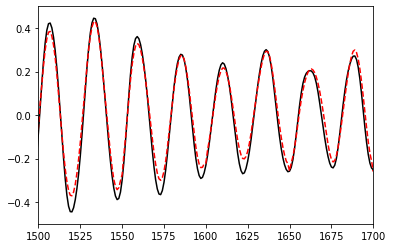

In [ ]:
y_pred = model.predict(x_pred, workers=16, use_multiprocessing=True, batch_size=params['minibatch_size'])
plt.plot(y_actual.reshape((-1,1)),'-k')
plt.plot(y_pred[:,:,1].reshape((-1,1)),'--r')
plt.xlim(1500,1700)
plt.ylim(-.5,.5)

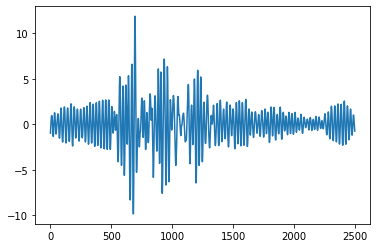

In [ ]:
i = 50
df = get_simulate(i, params)
df[col_mappings['inputs']] = real_scalers.transform(df[col_mappings['inputs']].values)
data_test = df_to_data(df, col_mappings, params)

x_pred  =  data_test['inputs'][:2500:50]
y_actual=  data_test['outputs'][:2500:50]
plt.plot(y_actual.reshape(-1,1))

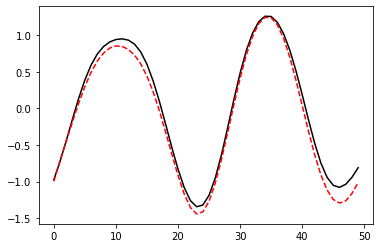

In [ ]:
i=0
x_hybrid = x_pred[i:i+1,:,:]
y_hybrid = y_actual[i:i+1,:,:]
y_pred = model.predict(x_hybrid, workers=16, use_multiprocessing=True, batch_size=params['minibatch_size'])
x_hybrid[:,-50:,0] = y_pred[:,:,1]
plt.plot(y_hybrid.reshape((-1,1)),'-k')
plt.plot(y_pred[:,:,0].reshape((-1,1)),'--r')

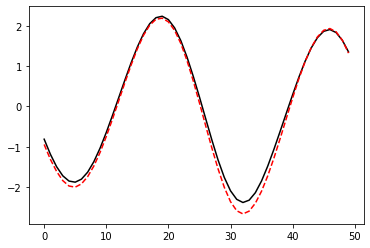

In [ ]:
i+=1
x_hybrid[:,:,1:] = x_pred[i:i+1,:,1:] 
x_hybrid[:,:-50,0] = x_hybrid[:,50:,0]
x_hybrid[:,-50:,0] = x_pred[i:i+1,-50:,0] 
y_hybrid = y_actual[i:i+1,:,:]
y_pred = model.predict(x_hybrid, workers=16, use_multiprocessing=True, batch_size=params['minibatch_size'])
plt.plot(y_hybrid.reshape((-1,1)),'-k')
plt.plot(y_pred[:,:,0].reshape((-1,1)),'--r')
x_hybrid[:,-50:,0] = y_pred[:,:,1]

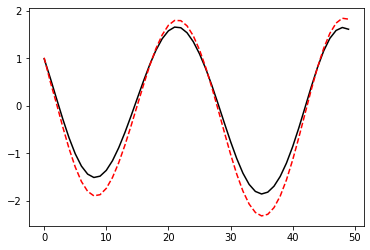

In [ ]:
i+=1
x_hybrid[:,-50:,0] = y_pred[:,:,1]
x_hybrid[:,:-50,:] = x_hybrid[:,50:,:]
x_hybrid[:,-50:,:] = x_pred[i:i+1,-50:,:] 
x_hybrid[:,:-50,1]=0
y_hybrid = y_actual[i:i+1,:,:]
y_pred = model.predict(x_hybrid, workers=16, use_multiprocessing=True, batch_size=params['minibatch_size'])
plt.plot(y_hybrid.reshape((-1,1)),'-k')
plt.plot(y_pred[:,:,0].reshape((-1,1)),'--r')

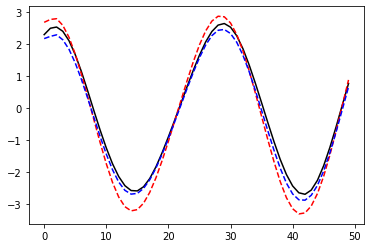

In [ ]:
i+=1
x_hybrid[:,-50:,0] = y_pred[:,:,1]
x_hybrid[:,:-50,:] = x_hybrid[:,50:,:]
x_hybrid[:,-50:,:] = x_pred[i:i+1,-50:,:] 
y_hybrid = y_actual[i:i+1,:,:]
y_pred = model.predict(x_hybrid, workers=16, use_multiprocessing=True, batch_size=params['minibatch_size'])
y0_pred = model.predict(x_pred[i:i+1,:,:], workers=16, use_multiprocessing=True, batch_size=params['minibatch_size'])
plt.plot(y_hybrid.reshape((-1,1)),'-k')
plt.plot(y_pred[:,:,0].reshape((-1,1)),'--r')
plt.plot(y0_pred[:,:,0].reshape((-1,1)),'--b')

## MAX MIN - TABLE

In [ ]:
# model.load_weights('./electricity/saved_models/electricity/fixed/aaa.check')
model.load_weights(filepath=os.path.join(params['model_folder'], 'eee.check')) 

In [ ]:
id = 130
print(GMfact[id], GMfile[id])
df = get_simulate(id, params)
df[col_mappings['inputs']] = real_scalers.transform(df[col_mappings['inputs']].values)
data_test = df_to_data(df, col_mappings, params)

x_actual  =  data_test['inputs'][:2500:50]
y_actual=  data_test['outputs'][:2500:50]
print(x_actual.shape, y_actual.shape)

0.7 kardista
(50, 550, 2) (50, 50, 1)


In [ ]:
motion = np.empty(3000)
y_rep_all = np.empty(3000)
y_true  = np.empty(3000)

motion[0:500]  =   x_actual[0,0:500,1]
motion[500:] = x_actual[:,-50:,1].reshape(-1)

y_true[0:500] = x_actual[0,0:500,0]
y_true[500:] = x_actual[:,-50:,0].reshape(-1)

x_hybrid = x_actual[0:1,:,:]
y_rep_all = y_true.copy()
y_max = y_true.copy()
y_min = y_true.copy()



In [ ]:
for j in range(1,20):
  idx = 500 + 50*j
  x_hybrid[0,0:500,0] = y_rep_all[idx - 500 : idx]
  x_hybrid[0,:,1] = motion[idx-500 : idx+50]
  y_pred_rep = model.predict(x_hybrid, workers=16, use_multiprocessing=True, batch_size=params['minibatch_size'])
  
  y_rep_all[idx : idx+50] = y_pred_rep[0,:,1]
  y_min[idx : idx+50] = y_pred_rep[0,:,0]
  y_max[idx : idx+50] = y_pred_rep[0,:,2]

 


(250.0, 350.0)

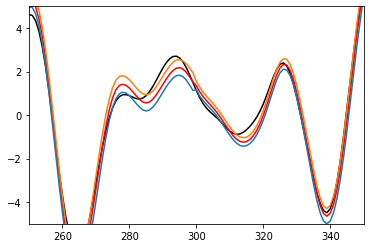

In [ ]:
plt.plot(y_true[750:1250],'-k')
plt.plot(y_rep_all[750:1250],'-r')
plt.plot(y_min[750:1250])
plt.plot(y_max[750:1250])
plt.ylim(-5,5)
plt.xlim(250,350)

In [ ]:
id = 130
print(GMfact[id], GMfile[id])
df = get_simulate(id, params)
df[col_mappings['inputs']] = real_scalers.transform(df[col_mappings['inputs']].values)
data_test = df_to_data(df, col_mappings, params)

x_actual  =  data_test['inputs'][:2500:50]
y_actual=  data_test['outputs'][:2500:50]
print(x_actual.shape, y_actual.shape)

0.7 kardista
(50, 550, 2) (50, 50, 1)


In [ ]:
motion = np.empty(3000)
y_rep_all = np.empty(3000)
y_true  = np.empty(3000)

motion[0:500]  =   x_actual[0,0:500,1]
motion[500:] = x_actual[:,-50:,1].reshape(-1)

y_true[0:500] = x_actual[0,0:500,0]
y_true[500:] = x_actual[:,-50:,0].reshape(-1)

x_hybrid = x_actual[0:1,:,:]
y_rep_all = y_true.copy()



In [ ]:
for j in range(1,50):
  idx = 500 + 50*j
  x_hybrid[0,0:500,0] = y_rep_all[idx - 500 : idx]
  x_hybrid[0,:,1] = motion[idx-500 : idx+50]
  y_pred_rep = model.predict(x_hybrid, workers=16, use_multiprocessing=True, batch_size=params['minibatch_size'])
 
  y_rep_all[idx : idx+50] = y_pred_rep[0,:,1]


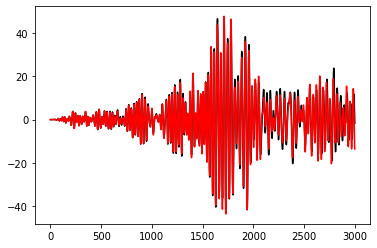

In [ ]:
plt.plot(y_true, 'k')
plt.plot(y_rep_all,'r')
# plt.xlim(750,1250)
# plt.ylim(-20,20)

In [ ]:
y_rep_scale = output_scalers.inverse_transform(y_rep_all) * 20
y_true_scale = output_scalers.inverse_transform(y_true) * 20

dist_rep = dtw.distance(y_true_scale, y_rep_scale)
dist_rep

19.441177935153142

In [ ]:
id = 117
print(GMfact[id], GMfile[id])


1.0 taiwan_2


In [ ]:
id = 117
model.load_weights(filepath=os.path.join(params['model_folder'], 'eee.check')) 
df = get_simulate(id, params)
df[col_mappings['inputs']] = real_scalers.transform(df[col_mappings['inputs']].values)
data_test = df_to_data(df, col_mappings, params)
x_actual  =  data_test['inputs'][:2500:50]
y_actual=  data_test['outputs'][:2500:50]
motion = np.empty(3000)

y_rep_all = np.empty(3000)
y_true  = np.empty(3000)
motion[0:500]  =   x_actual[0,0:500,1]
motion[500:] = x_actual[:,-50:,1].reshape(-1)
y_true[0:500] = x_actual[0,0:500,0]
y_true[500:] = x_actual[:,-50:,0].reshape(-1)
x_hybrid = x_actual[0:1,:,:]
y_rep_all = y_true.copy()

for j in range(1,50):
  idx = 500 + 50*j
  x_hybrid[0,0:500,0] = y_rep_all[idx - 500 : idx]
  x_hybrid[0,:,1] = motion[idx-500 : idx+50]
  y_pred_rep = model.predict(x_hybrid, workers=16, use_multiprocessing=True, batch_size=params['minibatch_size'])
 
  y_rep_all[idx : idx+50] = y_pred_rep[0,:,1]

y_rep_scale = output_scalers.inverse_transform(y_rep_all) * 20
y_true_scale = output_scalers.inverse_transform(y_true) * 20

dist_rep = dtw.distance(y_true_scale, y_rep_scale)
dist_rep

16.53913296697926

## overlap

In [ ]:
import numpy as np
from scipy.spatial.distance import euclidean

from fastdtw import fastdtw

x = np.array([[1,1], [2,2], [3,3], [4,4], [5,5]])
y = np.array([[2,2], [3,3], [4,4]])
distance, path = fastdtw(x, y, dist=euclidean)
print(distance)

2.8284271247461903


In [ ]:
distance, path = fastdtw(x, x*10, dist=euclidean)
print(distance)

190.91883092036784


In [ ]:
# model.load_weights('./electricity/saved_models/electricity/fixed/aaa.check')
model.load_weights(filepath=os.path.join(params['model_folder'], 'eee.check')) 

In [ ]:
id = 130
print(GMfact[id], GMfile[id])
df = get_simulate(id, params)
df[col_mappings['inputs']] = real_scalers.transform(df[col_mappings['inputs']].values)
data_test = df_to_data(df, col_mappings, params)

x_actual  =  data_test['inputs'][:2500:50]
y_actual=  data_test['outputs'][:2500:50]
print(x_actual.shape, y_actual.shape)

0.7 kardista
(50, 550, 2) (50, 50, 1)


In [ ]:
motion = np.empty(3000)
y_one_all = np.empty(3000)
y_rep_all = np.empty(3000)
y_true  = np.empty(3000)

motion[0:500]  =   x_actual[0,0:500,1]
motion[500:] = x_actual[:,-50:,1].reshape(-1)

y_one_all[0:500] = x_actual[0,0:500,0]
y_rep_all[0:500] = x_actual[0,0:500,0]
y_true[0:500] = x_actual[0,0:500,0]

y_one_all[500:] = x_actual[:,-50:,0].reshape(-1)
y_rep_all[500:] = x_actual[:,-50:,0].reshape(-1)
y_true[500:] = x_actual[:,-50:,0].reshape(-1)

x_hybrid = x_actual[0:1,:,:]


In [ ]:
for j in range(1,20):
  idx = 500 + 50*j
  x_hybrid[0,0:500,0] = y_rep_all[idx - 500 : idx]
  x_hybrid[0,:,1] = motion[idx-500 : idx+50]
  y_pred_rep = model.predict(x_hybrid, workers=16, use_multiprocessing=True, batch_size=params['minibatch_size'])
  y_pred_one = model.predict(x_actual[j:j+1,:,:], workers=16, use_multiprocessing=True, batch_size=params['minibatch_size'])
  
  y_one_all[idx : idx+50] = y_pred_one[0,:,1]
  y_rep_all[idx : idx+50] = y_pred_rep[0,:,1]

 


(-20.0, 20.0)

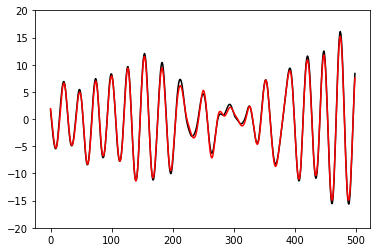

In [ ]:
plt.plot(y_true[750:1250],'-k')
plt.plot(y_rep_all[750:1250],'-r')
plt.ylim(-20,20)

In [ ]:
y_true.shape

(3000,)

In [ ]:
with open('compare_SDAN.p','wb') as f:
  pickle.dump(y_true[750:1250],f)
  pickle.dump(y_rep_all[750:1250],f)


In [ ]:
y_one_scale = output_scalers.inverse_transform(y_one_all) * 20
y_rep_scale = output_scalers.inverse_transform(y_rep_all) * 20
y_true_scale = output_scalers.inverse_transform(y_true) * 20



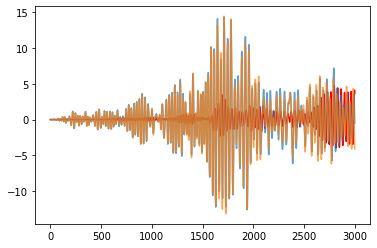

In [ ]:
rms = y_true_scale - y_rep_scale
plt.plot(rms,'r')
plt.plot(y_true_scale, alpha=0.7)
plt.plot(y_rep_scale,  alpha=0.7)
# plt.xlim(2500,3000)

In [ ]:
dist, path = fastdtw(y_true_scale, y_rep_scale, dist=euclidean)
print(dist)
dist, path = fastdtw(y_true_scale, y_one_scale, dist=euclidean)
print(dist)

829.072391181559
343.08705937830877


In [ ]:
# !pip install dtaidistance
from dtaidistance import dtw

In [ ]:
from dtaidistance import dtw
s1 = [0, 0, 1, 2, 1, 0, 1, 0, 0]
s2 = [0, 1, 2, 0, 0, 0, 0, 0, 0]
distance = dtw.distance(s1, s2)
print(distance)

1.4142135623730951


In [ ]:
dist = dtw.distance(y_true_scale, y_one_scale)
print(dist)
dist = dtw.distance(y_true_scale, y_rep_scale)
print(dist)

10.360019511726316
19.44116135050248


In [ ]:
dist = dtw.distance(y_true_scale, y_true_scale)
print(dist)

0.0


In [ ]:
dist = dtw.distance(y_true_scale, y_true_scale*10)
print(dist)

1656.6679766160871


In [ ]:
dist = dtw.distance(10*y_true_scale, y_true_scale)
print(dist)

1656.6679766160871


In [ ]:
rms = y_true_scale - y_one_scale

plt.plot(rms,'r')
plt.plot(y_true_scale, alpha=0.7)
plt.plot(y_one_scale, alpha=0.7)


In [ ]:
df_true = pd.DataFrame(y_true_scale)
df_rep = pd.DataFrame(y_rep_scale)
w = 50
mv_true = df_true.rolling(window=w).mean()[0].values
mv_rep = df_rep.rolling(window=w).mean()[0].values
mv_diff = mv_true - mv_rep

plt.plot(mv_diff,'r')
plt.plot(y_true_scale, alpha=0.7)
plt.plot(y_one_scale, alpha=0.7)


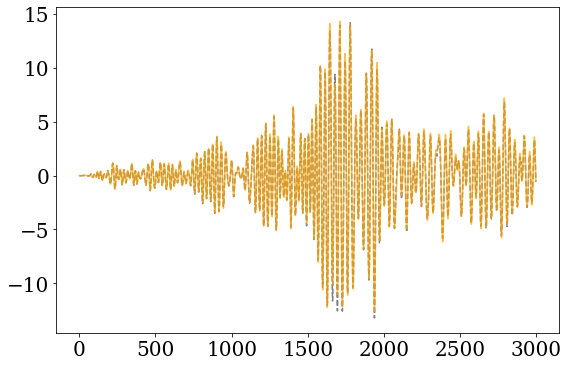

In [ ]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from matplotlib import rcParams, rc
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Time New Roman']
fsize = 20
rcParams.update({'font.size': fsize})

plt.figure(figsize=(9, 6))

df_true = pd.DataFrame(y_true_scale)
df_rep = pd.DataFrame(y_rep_scale)
w = 50
mv_true = df_true.rolling(window=w).mean()[0].values
mv_rep = df_rep.rolling(window=w).mean()[0].values
mv_diff = mv_true - mv_rep

# plt.plot(mv_diff,'r')
plt.plot(y_one_scale, '--k', alpha=0.5,linewidth=1.5, markersize = 2)
plt.plot(y_true_scale, 'orange', alpha=0.7,linewidth=1.5)



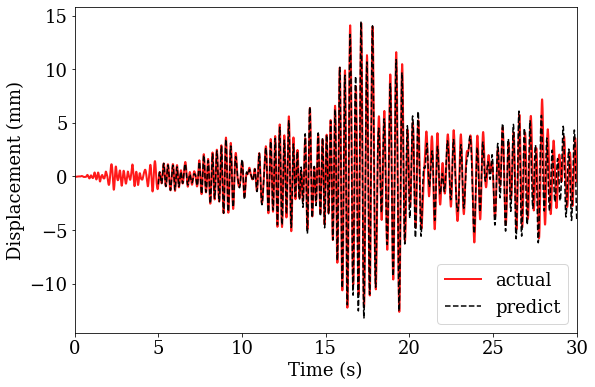

In [ ]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from matplotlib import rcParams, rc
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Time New Roman']
fsize = 18
rcParams.update({'font.size': fsize})

plt.figure(figsize=(9, 6))
t = np.linspace(0,30, len(y_rep_all))


plt.plot(t, y_true_scale,'-r', linewidth=2, alpha=0.9)
plt.plot(t[500:], y_rep_scale[500:],'--k', linewidth=1.5)
plt.xlim(0,30)
plt.xlabel('Time (s)')
plt.ylabel('Displacement (mm)')
plt.legend(['actual', 'predict'], loc='lower right')
plt.savefig('overlap.png', dpi=400)

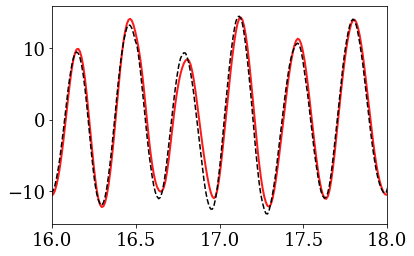

In [ ]:
plt.plot(t, y_true_scale,'-r', linewidth=2, alpha=0.9)
plt.plot(t, y_rep_scale,'--k', linewidth=1.5)
plt.xlim(16,18)
plt.savefig('sub_lap_2.png', dpi=200)

## Run statistic

In [ ]:
id = 130
print(GMfact[id], GMfile[id])
df = get_simulate(id, params)
df[col_mappings['inputs']] = real_scalers.transform(df[col_mappings['inputs']].values)
data_test = df_to_data(df, col_mappings, params)

x_actual  =  data_test['inputs'][:2500:50]
y_actual=  data_test['outputs'][:2500:50]


In [ ]:
motion = np.empty(3000)
y_one_all = np.empty(3000)
y_rep_all = np.empty(3000)
y_true  = np.empty(3000)

motion[0:500]  =   x_actual[0,0:500,1]
motion[500:] = x_actual[:,-50:,1].reshape(-1)

y_one_all[0:500] = x_actual[0,0:500,0]
y_rep_all[0:500] = x_actual[0,0:500,0]
y_true[0:500] = x_actual[0,0:500,0]

y_one_all[500:] = x_actual[:,-50:,0].reshape(-1)
y_rep_all[500:] = x_actual[:,-50:,0].reshape(-1)
y_true[500:] = x_actual[:,-50:,0].reshape(-1)

x_hybrid = x_actual[0:1,:,:]


In [ ]:
for j in range(1,50):
  idx = 500 + 50*j
  x_hybrid[0,0:500,0] = y_rep_all[idx - 500 : idx]
  x_hybrid[0,:,1] = motion[idx-500 : idx+50]
  y_pred_rep = model.predict(x_hybrid, workers=16, use_multiprocessing=True, batch_size=params['minibatch_size'])
  y_pred_one = model.predict(x_actual[j:j+1,:,:], workers=16, use_multiprocessing=True, batch_size=params['minibatch_size'])
  
  y_one_all[idx : idx+50] = y_pred_one[0,:,1]
  y_rep_all[idx : idx+50] = y_pred_rep[0,:,1]


In [ ]:
# !pip install dtaidistance
from dtaidistance import dtw

In [ ]:
def cal_distance(id=130):

  print(GMfact[id], GMfile[id])
  df = get_simulate(id, params)
  df[col_mappings['inputs']] = real_scalers.transform(df[col_mappings['inputs']].values)
  data_test = df_to_data(df, col_mappings, params)
  x_actual  =  data_test['inputs'][:2500:50]
  y_actual=  data_test['outputs'][:2500:50]


  motion = np.empty(3000)
  y_one_all = np.empty(3000)
  y_rep_all = np.empty(3000)
  y_true  = np.empty(3000)

  motion[0:500]  =   x_actual[0,0:500,1]
  motion[500:] = x_actual[:,-50:,1].reshape(-1)
  y_one_all[0:500] = x_actual[0,0:500,0]
  y_rep_all[0:500] = x_actual[0,0:500,0]
  y_true[0:500] = x_actual[0,0:500,0]
  y_one_all[500:] = x_actual[:,-50:,0].reshape(-1)
  y_rep_all[500:] = x_actual[:,-50:,0].reshape(-1)
  y_true[500:] = x_actual[:,-50:,0].reshape(-1)

  x_hybrid = x_actual[0:1,:,:]

  for j in range(1,50):
    idx = 500 + 50*j
    x_hybrid[0,0:500,0] = y_rep_all[idx - 500 : idx]
    x_hybrid[0,:,1] = motion[idx-500 : idx+50]
    y_pred_rep = model.predict(x_hybrid, workers=16, use_multiprocessing=True, batch_size=params['minibatch_size'])
    y_pred_one = model.predict(x_actual[j:j+1,:,:], workers=16, use_multiprocessing=True, batch_size=params['minibatch_size'])    
    y_one_all[idx : idx+50] = y_pred_one[0,:,1]
    y_rep_all[idx : idx+50] = y_pred_rep[0,:,1]

  y_one_scale = output_scalers.inverse_transform(y_one_all) * 20
  y_rep_scale = output_scalers.inverse_transform(y_rep_all) * 20
  y_true_scale = output_scalers.inverse_transform(y_true) * 20

  dist_one = dtw.distance(y_true_scale, y_one_scale)
  dist_rep = dtw.distance(y_true_scale, y_rep_scale)


  return dist_rep

In [ ]:
dist = cal_distance(id=130)
dist

0.7 kardista


19.44116135050248

In [ ]:
dist = cal_distance(id=10)
dist

1.7 kardista


19.44116135050248

In [ ]:
list_dist = []
for id in range(100,110):
  dist = cal_distance(id)
  print(dist)
  list_dist.append(dist)

0.9 taiwan_1
16.167923093624708
1.0 taiwan_1
14.023435683912453
1.1 taiwan_1
19.470098374310293
1.2 taiwan_1
34.46306245579437
1.3 taiwan_1
24.19030120721723
1.4 taiwan_1
14.745770940279895
1.5 taiwan_1
17.577762540425244
1.6 taiwan_1
18.144949136144835
1.7 taiwan_1
28.724012062409184
1.8 taiwan_1
22.918920607497526


In [ ]:
for id in range(110,112):
  dist = cal_distance(id)
  print(dist)
  list_dist.append(dist)

1.9 taiwan_1
23.94633651089819
2.0 taiwan_1
23.72031749557377


In [ ]:
for id in range(96,100):
  print(id)
  dist = cal_distance(id)
  print(dist)
  list_dist.append(dist)

96
0.5 taiwan_1
8.75888425912343
97
0.6 taiwan_1
13.628958760503833
98
0.7 taiwan_1
15.426657917515342
99
0.8 taiwan_1
19.658908549436696


In [ ]:
for id in range(112,128):
  print(id)
  dist = cal_distance(id)
  print(dist)
  list_dist.append(dist)

112
0.5 taiwan_2
4.248592358981283
113
0.6 taiwan_2
4.332966299177799
114
0.7 taiwan_2
4.664002203521601
115
0.8 taiwan_2
5.908057835650213
116
0.9 taiwan_2
8.512359060323599
117
1.0 taiwan_2
16.539138961158912
118
1.1 taiwan_2
19.195121592640014
119
1.2 taiwan_2
13.332268884001852
120
1.3 taiwan_2
12.948298377292518
121
1.4 taiwan_2
13.472856443324018
122
1.5 taiwan_2
24.02943465465018
123
1.6 taiwan_2
25.974508525818568
124
1.7 taiwan_2
23.608543408922642
125
1.8 taiwan_2
31.813353661565998
126
1.9 taiwan_2
32.21888216010621
127
2.0 taiwan_2
65.99342051121819


In [ ]:
for id in range(128,144):
  dist = cal_distance(id)
  print(dist)
  list_dist.append(dist)

128
0.5 kardista
33.89663292471629
129
0.6 kardista
38.326090526641956
130
0.7 kardista
19.44116135050248
131
0.8 kardista
21.057097752868692
132
0.9 kardista
22.838111437868776
133
1.0 kardista
48.678780574306266
134
1.1 kardista
37.8449139415431
135
1.2 kardista
53.042375118252956
136
1.3 kardista
49.79011102288132
137
1.4 kardista
32.90914627734233
138
1.5 kardista
26.338822524942355
139
1.6 kardista
30.223909960515503
140
1.7 kardista
32.69693766007905
141
1.8 kardista
38.08327573619539
142
1.9 kardista
46.30572136853966
143
2.0 kardista
54.08101947996387


In [ ]:
# "make original"
# [19.441, 21.057, 22.838, 26.338, 30.223, 32.696, 32.909, 33.896, 37.84, 38.083, 38.326, 46.305, 48.678, 49.790, 53.042, 54.081]
# [4.248, 4.332, 4.664, 5.908, 8.512, 12.94, 13.33, 13.47, 16.53, 19.19, 23.60, 24.02, 25.97, 31.81, 32.21, 35.99]
# [8.758, 13.628, 14.023, 14.745, 15.426, 16.167, 17.577, 18.144, 19.470, 19.658, 22.918, 23.720, 23.946, 24.190, 28.724, 34.463]

In [ ]:
f = np.arange(0.5,2.1,0.1)
d1=np.array([10.758, 11.628, 13.023, 14.745, 15.426, 16.167, 17.577, 18.144, 19.470, 19.658, 21.918, 23.720, 24.946, 26.190, 29.724, 31.463])
d2=np.array([4.248, 4.932, 5.664, 6.908, 8.512, 12.94, 13.33, 14.47, 16.53, 19.19, 23.60, 24.02, 25.97, 28.81, 31.21, 33.99])
d3=np.array([19.441, 21.057, 22.838, 26.338, 30.223, 32.696, 32.909, 33.896, 37.84, 38.083, 40.326, 46.305, 48.678, 49.790, 53.042, 54.081])-10

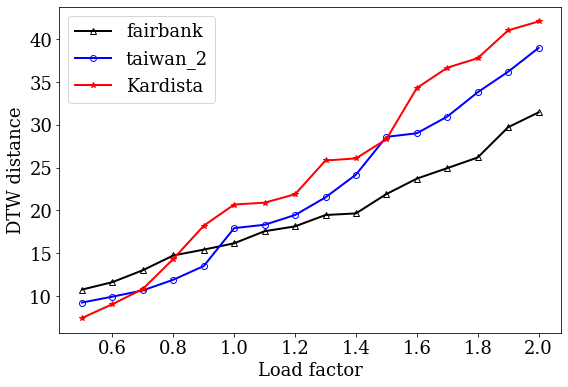

In [ ]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from matplotlib import rcParams, rc
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Time New Roman']
fsize = 18
rcParams.update({'font.size': fsize})

plt.figure(figsize=(9, 6))
t = np.linspace(0,30, len(y_rep_all))
plt.plot(f,d1,'-^k',mfc='none', linewidth=2.0, markersize=6.0)
plt.plot(f,d2+5,'-ob',mfc='none', linewidth=2.0, markersize=6.0)
plt.plot(f,d3-2,'-*r', linewidth=2.0, markersize=6.0)
plt.legend(['fairbank','taiwan_2','Kardista'])
plt.xlabel('Load factor')
plt.ylabel('DTW distance');
# plt.xlim(0.5,2.0)

In [ ]:
# 

In [ ]:
def get_motion(id):
  print(GMfile[id])
  df = pd.read_csv(f'{GMfile[id]}.g3', sep=' ', header=None)
  Ncol = len(list(df))
  g = np.zeros(len(df)*Ncol)
  for i in range(Ncol):
      g[i::Ncol]=df[i]

  g = g[~np.isnan(g)]
  g = g[::2]*GMfact[id]

  return g

fairbank
kardista
taiwan_2


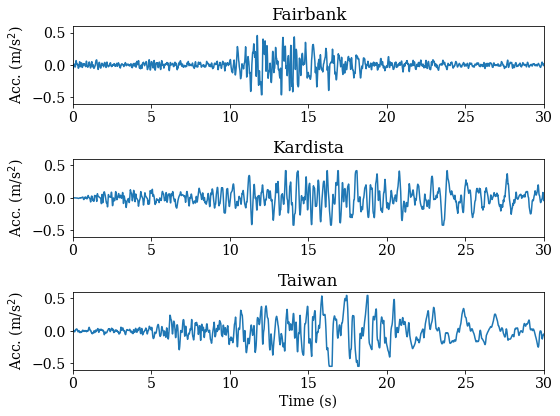

In [ ]:
fsize = 14
rcParams.update({'font.size': fsize})

# https://strongmotioncenter.org/vdc/scripts/plot.plx?stn=3035&evt=814
plt.figure(figsize=(8,6))

t = np.linspace(0,30,len(g))
g = get_motion(id = 60)*3
plt.subplot(311)
plt.plot(t,g)
plt.title('Fairbank')
plt.ylabel('Acc. (m/s$^2$)')
plt.xlim(0,30)
plt.ylim(-0.6,0.6)

t = np.linspace(0,30,len(g))
g = get_motion(id = 130)*4
plt.subplot(312)
plt.plot(t,g)
plt.title('Kardista')
plt.ylabel('Acc. (m/s$^2$)')
plt.xlim(0,30)
plt.ylim(-0.6,0.6)

t = np.linspace(0,30,len(g))
g = get_motion(id = 120)*3.5
plt.subplot(313)
plt.plot(t,g)
plt.title('Taiwan')
plt.xlabel('Time (s)')
plt.ylabel('Acc. (m/s$^2$)')
plt.xlim(0,30)
plt.ylim(-0.6,0.6)
plt.tight_layout()

In [ ]:
GMfile[15:150:15]

['kobe',
 'elsalvado',
 'indiana',
 'fairbank',
 'nenana',
 'tonalapa',
 'taiwan_1',
 'taiwan_2',
 'kardista']

In [ ]:
rms = np.mean(y_true_scale**2)**0.5
rms

3.449967886375365

In [ ]:
noise = np.random.randn(len(y_true_scale))

In [ ]:
dist = dtw.distance(y_true_scale, y_true_scale+noise)
print(dist)

46.241573984913586
